In [1]:
import os
import random
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# import eli5
from mpl_toolkits import mplot3d 
from sklearn.linear_model import LogisticRegression
import time
from sklearn.manifold import TSNE
# import eli5
# from eli5 import show_weights
# from eli5.sklearn import PermutationImportance
# import dabl

from pathlib import Path
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split         # Split data into train and test set

from utils import evaluate_classifier, get_sklearn_df 

# Allow more rows to be printed to investigate feature importance
pd.set_option('display.max_rows', 300)

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Spring barley',
    'Vinterbyg': 'Winter barley',
    'Vårhvede': 'Spring wheat',
    'Vinterhvede': 'Winter wheat',
    'Vinterrug': 'Winter rye',
    'Vårhavre': 'Spring oat',
    'Silomajs': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Permanent græs, normalt udbytte': 'Permanent grass',
    'Pil': 'Willow',
    'Skovdrift, alm.': 'Forest'
}


# Set seed for random generators
RANDOM_SEED = 42

# Seed the random generators
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

/Users/q3/opt/anaconda3/envs/lrp/lib/python3.6/site-packages/ipykernel_launcher.py:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import imp
import numpy as np
import os

import keras
import keras.backend
import keras.models

import innvestigate
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "/Users/MyFolders/Aarhus/innvestigate/examples/utils.py")
mnistutils = imp.load_source("utils_mnist", "/Users/MyFolders/Aarhus/innvestigate/examples/utils_mnist.py")

Using TensorFlow backend.
/Users/q3/opt/anaconda3/envs/lrp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/q3/opt/anaconda3/envs/lrp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/q3/opt/anaconda3/envs/lrp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/q3/opt/anaconda3/en

time: 2.52 s


In [3]:
netcdf_path = (PROJ_PATH / 'internship'/'FieldPolygons2019_stats').with_suffix('.nc') 
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 52769, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 67365067 67365062
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 543 ms


In [4]:
ds.close()

time: 82.5 ms


In [5]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns= ['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 17.9 s


In [6]:
class_names = ['Potato',
 'Spring barley',
 'Winter barley',
 'Spring wheat',
 'Winter wheat',
 'Winter rye',
 'Spring oat',
 'Maize',
 'Rapeseed',
 'Permanent grass',
 'Willow',
 'Forest']

time: 127 ms


In [7]:
def get_X_y(satellite_type):
    
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-01-01', '2019-12-31'), 
                                fields='all', 
                                satellite=satellite_type, 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")
    
    scaler = StandardScaler() 
    df_sklearn_remapped.iloc[:,5:] = scaler.fit_transform(df_sklearn_remapped.iloc[:,5:])
    
    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'
    return X, y, df_sklearn_remapped

time: 68.5 ms


In [8]:
def PCA_model(dimensions, data):
    pca = PCA(n_components=dimensions)
    principalComponents = pca.fit_transform(data)
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    return principalComponents

time: 67.8 ms


In [9]:
def PCA_model_lineplot(dimensions, data):
    pca = PCA(n_components=dimensions)
    principalComponents = pca.fit_transform(data)
    #print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    variance = pca.explained_variance_ratio_ #calculate variance ratios
    var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
    #var #cumulative sum of variance explained with [n] features
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Features')
    plt.title('PCA Analysis')
    plt.ylim(30,100.5)
    plt.style.context('seaborn-whitegrid')


    plt.plot(var)

time: 67.9 ms


In [10]:
def LDA_model(dimensions, data, y):
    model = LDA(n_components = dimensions)
    X_lda = model.fit_transform(data, y)
    print('Explained variation per principal component : {}'.format(model.explained_variance_ratio_))
    return model, X_lda

time: 75.1 ms


In [11]:
def LDA_model_lineplot(dimensions, data, y):
    model = LDA(n_components = dimensions)
    X_lda = model.fit_transform(data, y)
    #print('Explained variation per principal component: {}'.format(model.explained_variance_ratio_))
    variance = model.explained_variance_ratio_ #calculate variance ratios
    var=np.cumsum(np.round(model.explained_variance_ratio_, decimals=3)*100)
    print(list(var))
    #var #cumulative sum of variance explained with [n] features
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Features')
    #plt.xticks(rotation=90, horizontalalignment='center')
    plt.title('LDA Analysis')
    plt.ylim(30,100.5)
    plt.style.context('seaborn-whitegrid')


    plt.plot(var)

time: 70.2 ms


In [16]:
def LDA_plot_3D(X_lda, df_sklearn_remapped, crops, category):
    principalDf = pd.DataFrame(data = X_lda
                 , columns = ['LDA component 1', 'LDA component 2', 'LDA component 3'])
    finalDf = pd.concat([principalDf, df_sklearn_remapped[['Crop type']]], axis = 1)
    finalDf = finalDf.loc[finalDf['Crop type'].isin(crops)]
    fig = plt.figure(figsize = (10,10))
#     ax = fig.add_subplot(1,1,1) 
    ax = plt.axes(projection ="3d")
    ax.set_xlabel('LDA Component 1', fontsize = 15)
    ax.set_ylabel('LDA Component 2', fontsize = 15)
    ax.set_zlabel('LDA Component 3', fontsize = 15)
#     ax.set_title(title, fontsize = 20)
    #targets = class_names
    targets = crops
    colors = ['r', 'g', 'bisque', 'c', 'm', 'y', 'k', 'sienna', 'blue', 'orange', 'brown', 'pink']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['Crop type'] == target
        ax.scatter3D(finalDf.loc[indicesToKeep, 'LDA component 1']
                   , finalDf.loc[indicesToKeep, 'LDA component 2']
                   , finalDf.loc[indicesToKeep, 'LDA component 3']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    #plt.savefig('/Users/MyFolders/Aarhus/Figures/LDA_3D_' + category + '.png')

time: 70.3 ms


In [19]:
X, y, df_sklearn_remapped = get_X_y("S1A")

time: 40.8 s


In [20]:
feature_names = df_sklearn_remapped.columns[5:]

time: 131 ms


In [21]:
feature_names

Index(['2018-07-14_VV', '2018-07-26_VV', '2018-08-07_VV', '2018-08-19_VV',
       '2018-08-31_VV', '2018-09-12_VV', '2018-09-24_VV', '2018-10-06_VV',
       '2018-10-18_VV', '2018-10-30_VV',
       ...
       '2019-07-09_VV-VH', '2019-07-21_VV-VH', '2019-08-02_VV-VH',
       '2019-08-14_VV-VH', '2019-08-26_VV-VH', '2019-09-07_VV-VH',
       '2019-09-19_VV-VH', '2019-10-01_VV-VH', '2019-10-13_VV-VH',
       '2019-10-25_VV-VH'],
      dtype='object', length=114)

time: 84.9 ms


In [22]:
result = np.where((y == 0) | (y == 3) | (y == 4) | (y == 8) |(y == 11))
req_indices = result[0]
req_indices = list(req_indices)

time: 74.9 ms


In [23]:
X_req = X[req_indices] 
y_req = y[req_indices]

time: 96.9 ms


In [24]:
np.unique(y_req)

array([ 0,  3,  4,  8, 11], dtype=int8)

time: 80.3 ms


In [25]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X_req)

time: 134 ms


In [26]:
mapping = {
    0: 'Potato',
    1: 'Spring barley',
    2: 'Winter barley',
    3: 'Spring wheat',
    4: 'Winter wheat',
    5: 'Winter rye',
    6: 'Spring oat',
    7: 'Maize',
    8: 'Rapeseed',
    9: 'Permanent grass',
    10: 'Willow',
    11: 'Forest'
}

time: 88.1 ms


In [27]:
def explained_df(clf, feature_names):
    
    df_explanation = eli5.formatters.as_dataframe.explain_weights_df(clf, feature_names=list(feature_names), target_names=class_names)
    df_explanation = df_explanation.sort_values(by=['feature', 'target'])
    df_explanation['polarization'] = ''
    features = df_explanation['feature'].unique()
    features = features[:-1]  # The last features are the bias values
    df_bias_values = df_explanation[df_explanation['feature'] == '<BIAS>']

    df_explanation = df_explanation[df_explanation['feature'] != '<BIAS>']
    for feature in features:
        if feature[-5:] == 'VV-VH':
            df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV-VH'
            df_explanation = df_explanation.replace(feature, feature[:-6])
        elif feature[-2:] == 'VV':
            df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV'
            df_explanation = df_explanation.replace(feature, feature[:-3])
        else:
            df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VH'
            df_explanation = df_explanation.replace(feature, feature[:-3])
            
    return df_explanation

time: 74.3 ms


In [28]:
def plot_VV_VH(df_explanation, crop_type):
    data = df_explanation[df_explanation['target'] == crop_type]
    #data = data.loc[data['polarization'].isin(['VV', 'VH'])]
    #data = data.loc[data['target'].isin(['Forest', 'Rapeseed'])]
    plt.figure(figsize=(24, 8))
    plt.xticks(rotation=90, horizontalalignment='center')
    sns.set_context("talk")
    ax = sns.lineplot(x='feature', y='weight', hue='polarization', data=data, ci='sd').set_title(crop_type)

time: 83.8 ms


[53.1, 88.8, 96.39999999999999, 99.89999999999999]


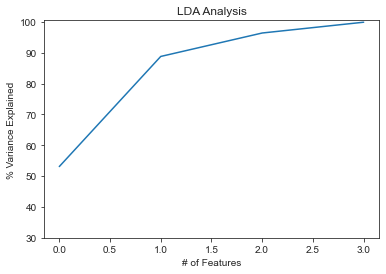

time: 763 ms


In [29]:
X_lda = LDA_model_lineplot(None, X1, y_req)

In [30]:
model_lda, X_lda_4D = LDA_model(None, X1, y_req)

Explained variation per principal component : [0.53119097 0.3571063  0.07627817 0.03542455]
time: 541 ms


In [31]:
X_lda_4D.shape

(17861, 4)

time: 97.7 ms


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_lda_4D, y_req, test_size=0.3, random_state=RANDOM_SEED)

time: 101 ms


In [36]:
from keras.utils import to_categorical
num_classes = 12
feature_vector_length = X_train.shape[1]
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

time: 78.1 ms


In [37]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
# Set the input shape
input_shape = (feature_vector_length,)
print(f'Feature shape: {input_shape}')

# Create the model
model = Sequential()
model.add(Dense(3, input_shape=input_shape, activation='relu'))
# model.add(Dense(30, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

Feature shape: (4,)
time: 377 ms


In [38]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train_encoded, epochs=20)

Epoch 1/20
12502/12502 [==============================] - 1s 61us/step - loss: 1.9473 - acc: 0.6291
Epoch 2/20
12502/12502 [==============================] - 1s 44us/step - loss: 1.0355 - acc: 0.8737
Epoch 3/20
12502/12502 [==============================] - 1s 43us/step - loss: 0.7433 - acc: 0.9297
Epoch 4/20
12502/12502 [==============================] - 1s 43us/step - loss: 0.5474 - acc: 0.9514
Epoch 5/20
12502/12502 [==============================] - 1s 41us/step - loss: 0.4182 - acc: 0.9578
Epoch 6/20
12502/12502 [==============================] - 1s 45us/step - loss: 0.3344 - acc: 0.9591
Epoch 7/20
12502/12502 [==============================] - 1s 43us/step - loss: 0.2799 - acc: 0.9597
Epoch 8/20
12502/12502 [==============================] - 1s 43us/step - loss: 0.2436 - acc: 0.9606
Epoch 9/20
12502/12502 [==============================] - 1s 43us/step - loss: 0.2190 - acc: 0.9601
Epoch 10/20
12502/12502 [==============================] - 1s 43us/step - loss: 0.2018 - acc: 0.9606

time: 11.6 s


In [39]:
train_results = model.evaluate(X_train, y_train_encoded, verbose=1)
print(f'Train results - Loss: {train_results[0]} - Accuracy: {train_results[1]}%')

12502/12502 [==============================] - 0s 19us/step
Train results - Loss: 0.15217010320452257 - Accuracy: 0.9609662454007358%
time: 340 ms


In [40]:
test_results = model.evaluate(X_test, y_test_encoded, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

5359/5359 [==============================] - 0s 22us/step
Test results - Loss: 0.1568065571485226 - Accuracy: 0.9619331964918828%
time: 198 ms


In [55]:
empty_array = np.empty((0, 4), int)
model_wo_sm = iutils.keras.graph.model_wo_softmax(model)
analyzer = innvestigate.create_analyzer("lrp.z", model_wo_sm)
for i in range(X_test.shape[0]):
    analysis = analyzer.analyze(X_test[i].reshape(1,4))
    empty_array = np.append(empty_array, analysis, axis=0)

empty_array.shape

(5359, 4)

time: 2.76 s


In [56]:
mapping = {
0: 'Potato',
1: 'Spring barley',
2: 'Winter barley',
3: 'Spring wheat',
4: 'Winter wheat',
5: 'Winter rye',
6: 'Spring oat',
7: 'Maize',
8: 'Rapeseed',
9: 'Permanent grass',
10: 'Willow',
11: 'Forest'
}

crop_tonumber = {
    'Potato': 0,
    'Spring barley': 1,
    'Winter barley': 2,
    'Spring wheat': 3,
    'Winter wheat': 4,
    'Winter rye': 5,
    'Spring oat': 6,
    'Maize': 7,
    'Rapeseed': 8,
    'Permanent grass': 9,
    'Willow': 10,
    'Forest': 11
}

time: 75.3 ms


In [57]:
def LDA_Sense(croptype):
    df_explanation = pd.DataFrame(data = empty_array, columns = ['x0', 'x1', 'x2', 'x3'])
    crop_number = crop_tonumber[croptype]
    result = np.where((y_test == crop_number))
    req_indices = result[0]
    req_indices = list(req_indices)
    df_explanation = df_explanation.iloc[req_indices]
    averaged_explanation = df_explanation.mean(axis=0).to_frame().reset_index()
    averaged_explanation.rename(columns={"index": "feature", 0: "weight"}, inplace = True)
    averaged_explanation.sort_values(by = "weight", inplace = True, ascending = False)
    display(averaged_explanation)
# averaged_explanation = pd.DataFrame(averaged_explanation, columns = ["FI"])
# averaged_explanation.sort_values(by = "index")

time: 93.4 ms


In [58]:
LDA_Sense("Potato")

,feature,weight
1,x1,0.038334
0,x0,0.033481
3,x3,0.017596
2,x2,-0.037659


time: 95.3 ms


In [59]:
LDA_Sense("Spring wheat")

,feature,weight
3,x3,2.375274
1,x1,2.338071
2,x2,-0.140898
0,x0,-0.359853


time: 96.6 ms


In [60]:
LDA_Sense("Winter wheat")

,feature,weight
1,x1,7.252565
0,x0,0.040495
2,x2,-0.112839
3,x3,-0.144461


time: 98.9 ms


In [61]:
LDA_Sense("Rapeseed")

,feature,weight
0,x0,9.592386
1,x1,0.309969
3,x3,-0.015908
2,x2,-0.120414


time: 100 ms


In [62]:
LDA_Sense("Forest")

,feature,weight
2,x2,5.936158
0,x0,1.100758
1,x1,0.060772
3,x3,0.007644


time: 131 ms
